# Creating Feature Matrix

In [1]:
import os
import shutil
import scipy
from scipy import stats
from skimage.io import imread, imsave
import numpy as np
from matplotlib import pyplot as plt

In [2]:
scipy.__version__

'1.5.4'

In [3]:
imgdir='/workspace/data/nissl_fetal'

In [4]:
all_fetal_img_path ='/images'

In [5]:
#  os.listdir(imgdir+all_fetal_img_path)

In [6]:
# i=0
feat_mat=[]
for imgfile in os.listdir(imgdir+all_fetal_img_path):
    img = imread(imgdir+all_fetal_img_path+'/'+imgfile)
    l = list(stats.describe(img[...,2].ravel()/255.0))[1:]
    img_feature=list(l[0])+l[1:]
    feat_mat.append(img_feature)


In [7]:
feat_mat=np.array(feat_mat)

In [8]:
feat_mat.shape

(3084, 6)

# Running clustering Algorithm

In [9]:
# !pip install scikit-learn

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(feat_mat)
kmeans.labels_

array([3, 0, 2, ..., 2, 2, 0], dtype=int32)

In [11]:
np.unique(kmeans.labels_,return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([ 743,   64, 2268,    9]))

In [12]:
def visualise_images(cluster_number,images_to_show,ret_list=False,img_show=True):
    i=0
    clust_n = np.where(np.array(kmeans.labels_) == cluster_number)
    clust_n_imglist=np.array(os.listdir(imgdir+all_fetal_img_path))[clust_n]
    if ret_list:
        return clust_n_imglist
    for imgfile in clust_n_imglist:
        img = imread(imgdir+all_fetal_img_path+'/'+imgfile)
        plt.imshow(img)
        plt.show()
        i+=1
        if i == images_to_show:
            break

In [13]:
cluster_directory = "images_clustered"
path = os.path.join(imgdir, cluster_directory)
try:
    os.mkdir(path)
except:
    FileExistsError

In [15]:
#saving in clustered images in folder 
for i in np.unique(kmeans.labels_,return_counts=True)[0]:
    sub_folder = 'clust_number_' + str(i)
    new_folder_path = os.path.join(path, sub_folder)
    try:
        os.mkdir(new_folder_path)
        for imgfile in visualise_images(i,5,True,False):
            source_path = imgdir+all_fetal_img_path+'/'+imgfile
            dest_path = new_folder_path
            shutil.copy(source_path,dest_path)
    except:
        FileExistsError


# Running Inference 

In [5]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.intra_op_parallelism_threads=1
config.inter_op_parallelism_threads=1
set_session(tf.Session(config=config))

In [5]:
import sys
sys.path.append('../..')
from mrcnn.config import Config
import numpy as np
from mrcnn import model as modellib

Using TensorFlow backend.


In [6]:
class NucleusConfig(Config):
    """Configuration for training on the nissl segmentation dataset. while using command "train"
    """
    # Give the configuration a recognizable name
    NAME = "nissl"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1 # since multiprocessing doesn't work

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + cell

    # Number of training and validation steps per epoch
    # 238 is the size of train set
    STEPS_PER_EPOCH = 218 // (IMAGES_PER_GPU * GPU_COUNT)
    VALIDATION_STEPS = max(1, 20 // (IMAGES_PER_GPU * GPU_COUNT))

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nissl and BG
    DETECTION_MIN_CONFIDENCE = 0.7

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2, 4]

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    # setting means for R and G to 0 since cells are mostly blue
    MEAN_PIXEL = np.array([0, 0, 103.9])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    IMAGE_CHANNEL_COUNT = 3

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 400

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 800
# In[5]:
class NucleusInferenceConfig(NucleusConfig):
    """Test-time configurations. while using command "test" or "detect"
    """
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9
    USE_MINI_MASK = False


In [7]:
def combine_out_array(out):
    out_combined = out[...,0].astype(np.uint16)
    for x in range(1,out.shape[-1]):
        out_combined += out[...,x].astype(np.uint16)*(x+1) 
    return out_combined

In [8]:
config = NucleusInferenceConfig()
model = modellib.MaskRCNN(mode='inference', config=config, model_dir='./logs')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
model.load_weights('mask_rcnn_nucleus_NISSL.h5', by_name=True) #4minutes

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


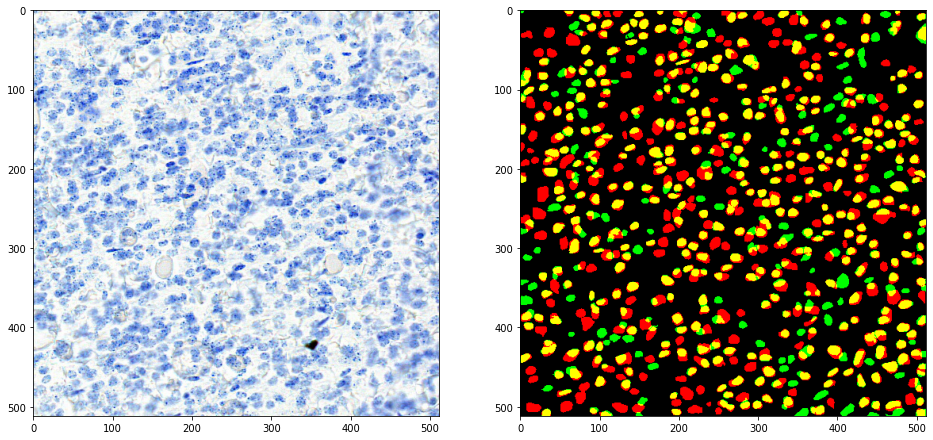

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


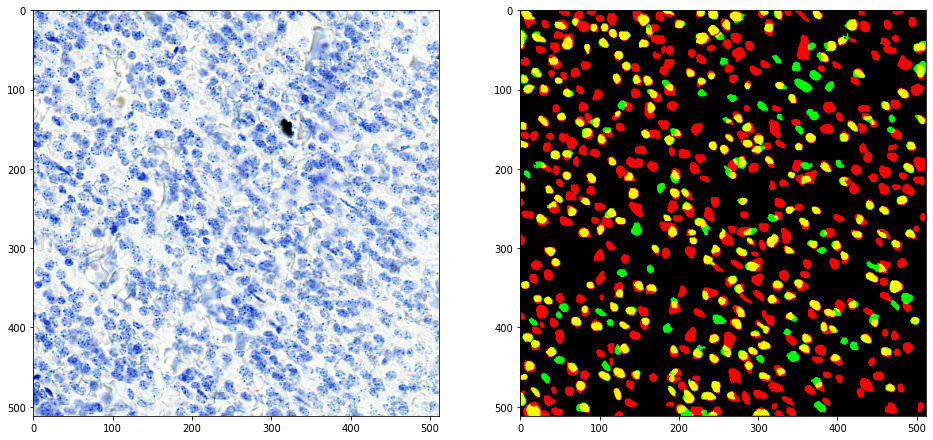

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


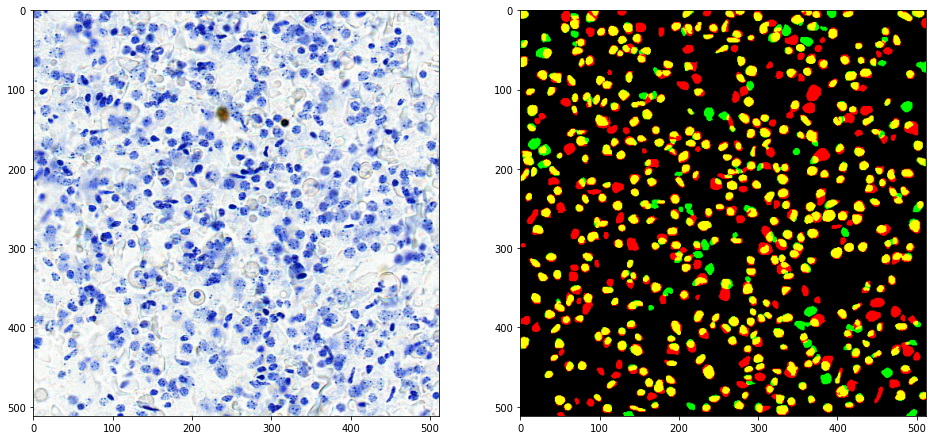

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


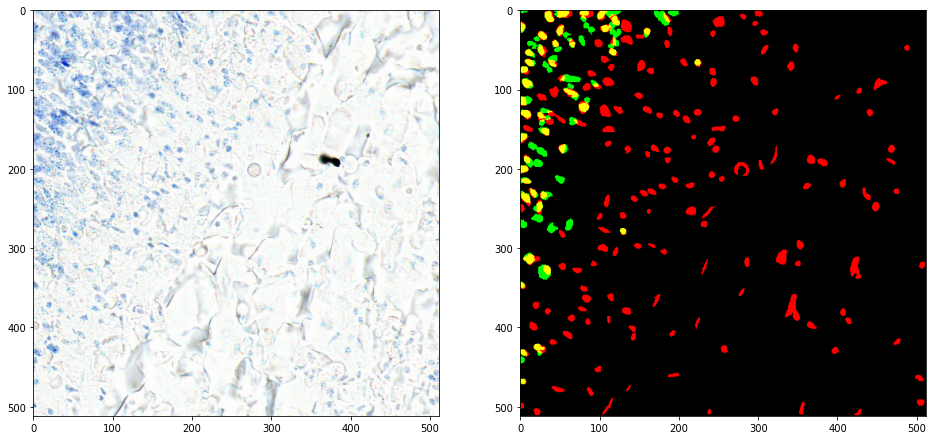

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


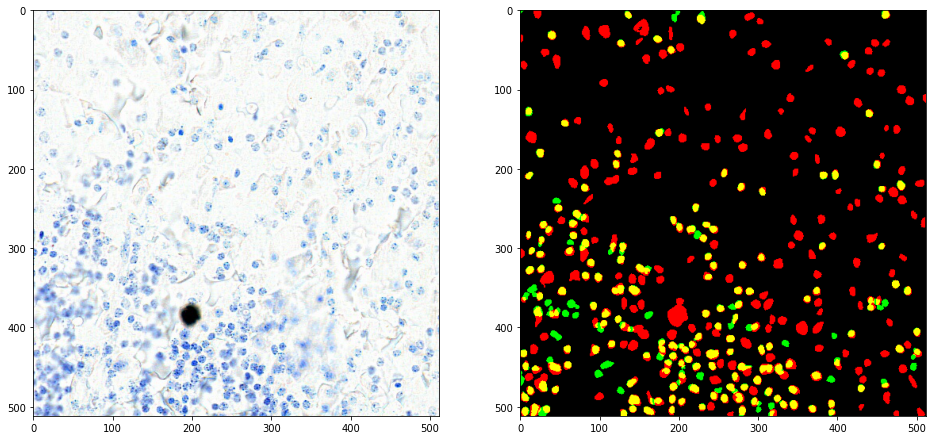

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


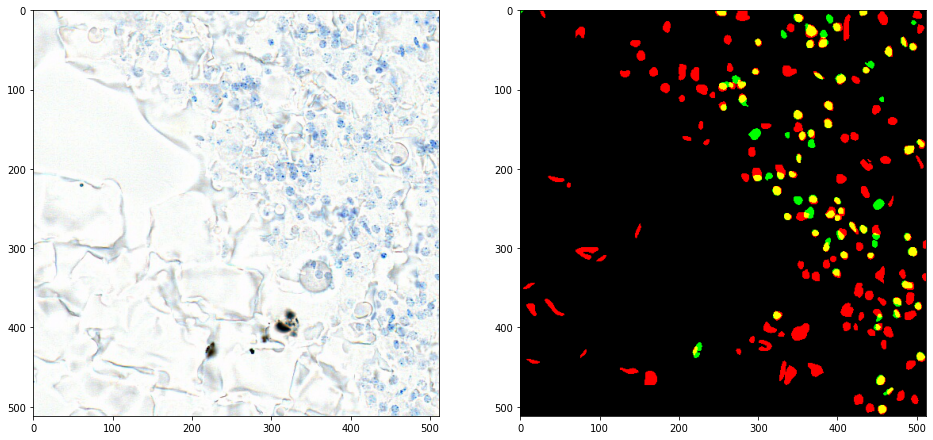

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


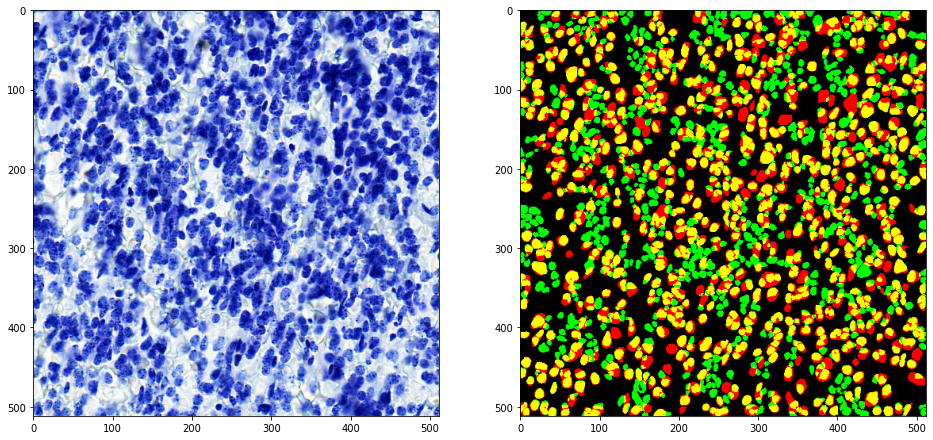

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


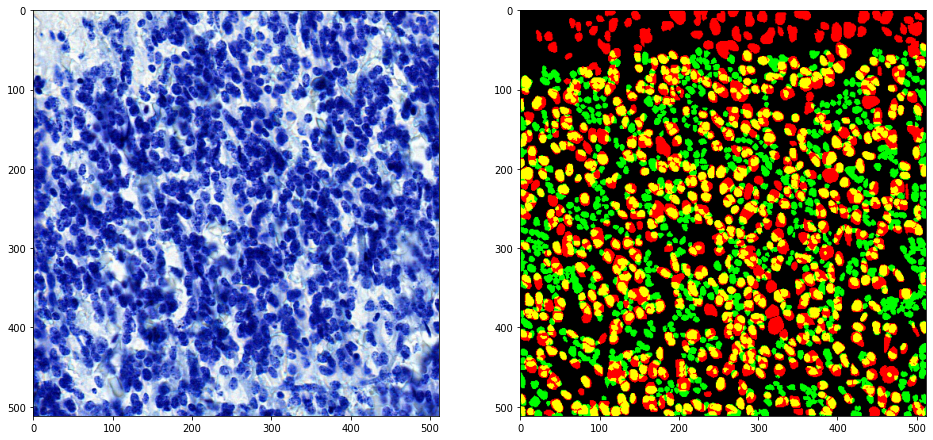

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


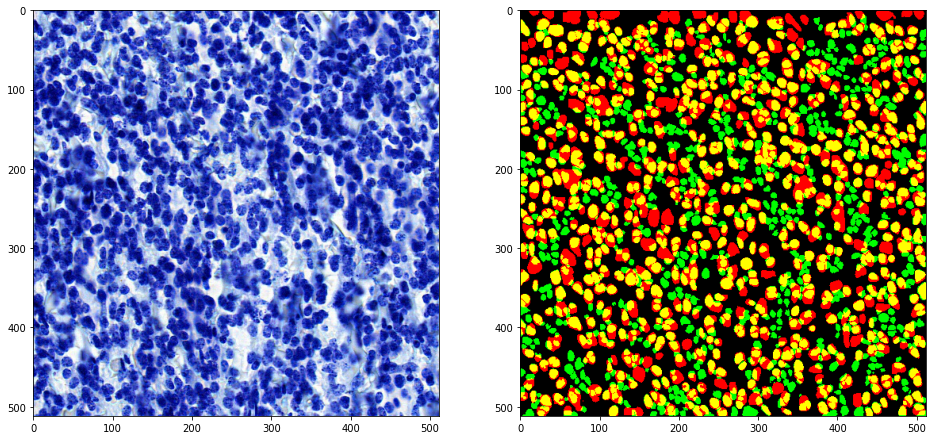

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


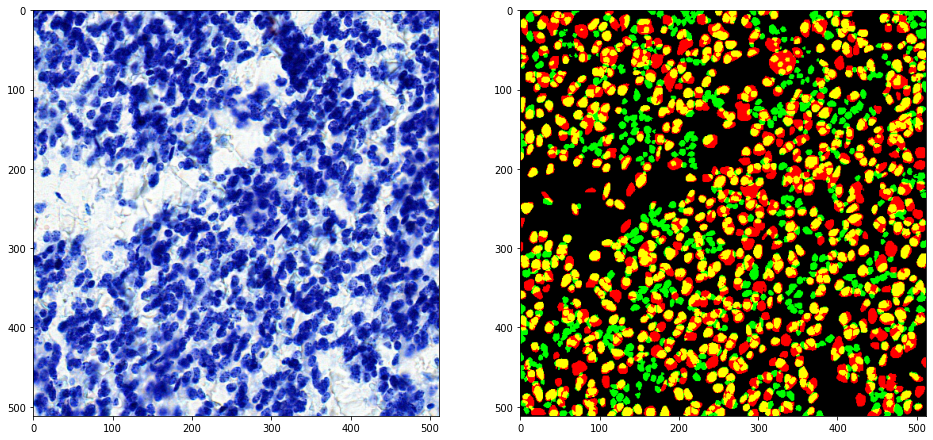

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


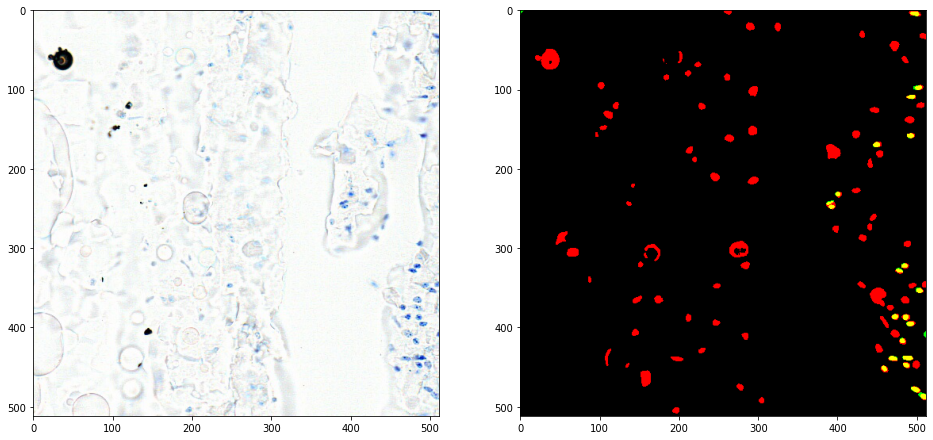

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


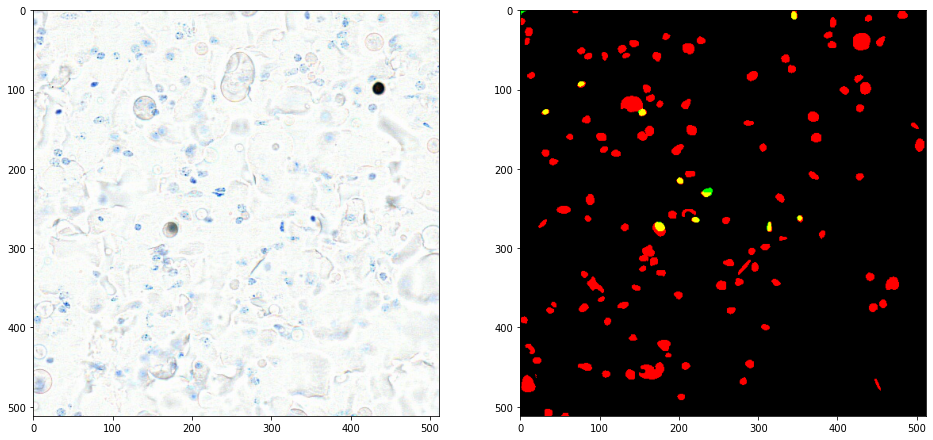

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


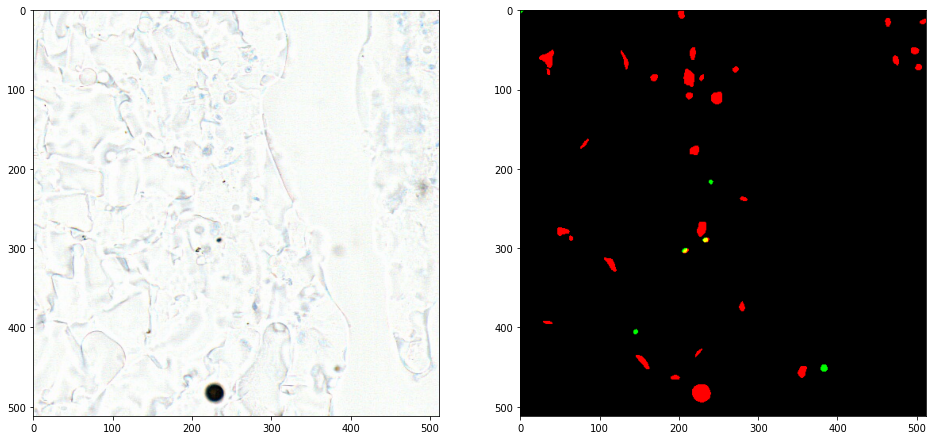

In [15]:
selected_samples_path = '/workspace/data/images_clustered/selected_samples'
for folder_name in os.listdir(selected_samples_path):
    sample_img_list = os.listdir(os.path.join(selected_samples_path,folder_name))
    for imgfile in sample_img_list:
        img_crop = imread(os.path.join(selected_samples_path,folder_name,imgfile))
        
        r = model.detect([img_crop],verbose=1)
        out = r[0]['masks']
        combined_out = combine_out_array(out)
        annot = imread(imgdir+'/img_annotations/' + imgfile.split('.')[0]+'.png')

        plt.figure(figsize=(16,16))
        plt.subplot(1,2,1)
        plt.imshow(img_crop)
        plt.subplot(1,2,2)
#         ann = annot[...,0]>0).astype(np.uint8)
        tmp = np.dstack([(combined_out>0).astype(np.uint8)*255,annot[...,0],np.zeros_like(annot[...,0])])
        plt.imshow(tmp) 
        plt.show()


In [12]:
print('hello')

hello


In [11]:
r = model.detect([img_crop],verbose=1)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.90000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32



In [13]:
out = r[0]['masks']
out.shape

(512, 512, 0)

In [15]:
out = r[0]['masks']
combined_out = combine_out_array(out)
annot = imread(imgdir+'/img_annotations' + imgfile.split('.')[0].split('_')[-1]+'.png')

plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(img_crop)
plt.subplot(1,2,2)
# ann = annot[...,0]>0).astype(np.uint8)
tmp = np.dstack([(combined_out>0).astype(np.uint8)*255,annot[...,0],np.zeros_like(annot[...,0])])
plt.imshow(tmp) 
plt.show()

IndexError: index 0 is out of bounds for axis 2 with size 0

In [ ]:
# for i in np.unique(kmeans.labels_,return_counts=True)[0]:
#     print('clust_number ' , i)
#     imgfile_list = visualise_images(i,5,True,False)

#     for imgfile in imgfile_list:
#         img_crop = imread(imgdir + all_fetal_img_path+'/'+imgfile)
#         r = model.detect([img_crop],verbose=1)
#         out = r[0]['masks']
#         combined_out = combine_out_array(out)
#         annot = imread(imgdir+all_fetal_annot_path+'/' + imgfile.split('.')[0].split('_')[-1]+'.png')

#         plt.figure(figsize=(16,16))
#         plt.subplot(1,2,1)
#         plt.imshow(img_crop)
#         plt.subplot(1,2,2)
#         plt.imshow((combined_out>0).astype(np.uint8) + 2*(annot[...,0]>0).astype(np.uint8) , cmap='hot')
#         plt.show()
#     break

In [ ]:
# imgfile.split('.')[0].split('_')[-1]